In [9]:
# Import libraries
import numpy as np
import pandas as pd
#For plotting
import matplotlib.pyplot as plt
import seaborn as sns
# For clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer

# For modelling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

In [10]:
m_results = pd.read_csv('./Data files/val-matches.csv')

In [11]:
m_results['Winner'] = np.where(m_results['Team 1 Score'] > m_results['Team 2 Score'], 1, 0)
# Sort rows by match id
m_results = m_results.sort_values(by=['Series Id'], ascending=True)
m_results = m_results.drop([
    'Match Id',
    'Series Id',
    'Event Name',
    'Win Condition',
    'Date',
    'Total Count',
    'Team 1 Id',
    'Team 2 Id',
    #'Team 1 Player Ids',
    #'Team 2 Player Ids',
    'Team 1 Score',
    'Team 2 Score',
    'Team 1 Score At Half',
    'Team 2 Score At Half', 
    "Team 1 Pistol Wins",
    "Team 1 Attacking Pistol Wins",
    "Team 1 Defending Pistol Wins",
    "Team 1 Attacking Wins",
    "Team 1 Attacking Losses",
    "Team 1 Defending Wins",
    "Team 1 Defending Losses",
    "Team 2 Pistol Wins",
    "Team 2 Attacking Pistol Wins",
    "Team 2 Defending Pistol Wins",
    "Team 2 Attacking Wins",
    "Team 2 Attacking Losses",
    "Team 2 Defending Wins",
    "Team 2 Defending Losses"
    ], axis=1)

#export df to csv
m_results.to_csv('./Data files/val-matches-cleaned.csv', index=False)

In [12]:
#read val-matches-cleaned.csv
val_matches = pd.read_csv('./Data files/val-matches-cleaned.csv')


In [13]:
def player_id_list(results, team_number):
    list_of_player_ids = []

    for index, row in results.iterrows():
        player_ids = row['Team ' + team_number + ' Player Ids']
        player_ids = player_ids[1:-1]
        player_ids = player_ids.split(',')
        player_ids = [int(i) for i in player_ids]
        list_of_player_ids.append(player_ids)
    return list_of_player_ids

def agents_to_list(results, team_number):
    list_of_agent_lists = []
    for index, row in results.iterrows():
        agents = row['Team ' + team_number + ' Agents'].split(',')
        for x in range(len(agents)):
            agents[x] = agents[x] + '_' + team_number
        list_of_agent_lists.append(agents)
    return list_of_agent_lists

In [14]:
val_matches['Team 1 Player Ids'] = player_id_list(val_matches, '1')
val_matches['Team 2 Player Ids'] = player_id_list(val_matches, '2')
val_matches['Team 1 Agents'] = agents_to_list(val_matches, '1')
val_matches['Team 2 Agents'] = agents_to_list(val_matches, '2')

In [15]:
from pathlib import Path  
# acs = pd.read_csv('./Data files/acs.csv')
# agent_wr = pd.read_csv('./Data files/agent-win-rates.csv')
# agent_picks = pd.read_csv('./Data files/agent-picks.csv')
# aim = pd.read_csv('./Data files/aim.csv')
# assists = pd.read_csv('./Data files/assists.csv')
# clutches = pd.read_csv('./Data files/clutches.csv')
# damage = pd.read_csv('./Data files/damage.csv')
# defusals = pd.read_csv('./Data files/defusals.csv')
# headshots = pd.read_csv('./Data files/headshots.csv')
# kd = pd.read_csv('./Data files/kd.csv')
# multikill = pd.read_csv('./Data files/multi-kills.csv')
# plants = pd.read_csv('./Data files/plants.csv')
# spend = pd.read_csv('./Data files/spend.csv')
# playernames = pd.read_csv('./Data files/player-names.csv')
# playernames.drop(['Team'], axis=1, inplace=True)
# #weapon_picks = pd.read_csv('./Data files/weapon-picks.csv')


# # Merge the dataframes
# df = pd.merge(acs, aim, on=['Ign', 'Team'])
# #df = pd.merge(df, agent_picks, on=['Ign', 'Team'])
# #df = pd.merge(df, aim, on=['Ign', 'Team'])
# df = pd.merge(df, clutches, on=['Ign', 'Team'])
# df = pd.merge(df, damage, on=['Ign', 'Team'])
# df = pd.merge(df, defusals, on=['Ign', 'Team'])
# df = pd.merge(df, headshots, on=['Ign', 'Team'])
# df = pd.merge(df, kd, on=['Ign', 'Team'])
# df = pd.merge(df, multikill, on=['Ign', 'Team'])
# df = pd.merge(df, plants, on=['Ign', 'Team'])
# df = pd.merge(df, spend, on=['Ign', 'Team'])
# df = pd.merge(df, playernames, on='Ign', how='inner')
# #df = pd.merge(df, weapon_picks, on=['Ign', 'Team'])

# df.drop_duplicates(subset=['Ign', 'Team'], inplace=True)

# filepath = Path('./Data files/merged.csv')  
# filepath.parent.mkdir(parents=True, exist_ok=True)  
# df.to_csv(filepath)  
# df.head(5)

df = pd.read_csv('./Data files/merged.csv')

In [16]:
# Create an elo system for each player
# Create a dictionary of players and their elo
elo_dict = {}
for index, row in df.iterrows():
    if row['Player Id'] not in elo_dict:
        elo_dict[row['Player Id']] = 1000

# Players with higher kd should have higher elo
# Players with higher acs should have higher elo

# Create a dictionary of players and their acs
acs_dict = {}
for index, row in df.iterrows():
    if row['Player Id'] not in acs_dict:
        acs_dict[row['Player Id']] = row['Acs']

# Create a dictionary of players and their kd
kd_dict = {}
for index, row in df.iterrows():
    if row['Player Id'] not in kd_dict:
        kd_dict[row['Player Id']] = row['Kd']
print(val_matches['Team 1 Player Ids'])


0       [1403, 17788, 1690, 2056, 10211]
1       [2056, 17788, 1403, 1690, 10211]
2         [1826, 2377, 2594, 2769, 2940]
3         [1826, 2377, 2769, 2594, 2940]
4         [1826, 2377, 2940, 2769, 2594]
                      ...               
1583       [3211, 2841, 398, 2483, 2716]
1584       [2483, 2841, 3211, 398, 2716]
1585       [2841, 398, 2483, 2716, 3211]
1586       [2483, 2841, 398, 2716, 3211]
1587       [2841, 3211, 398, 2716, 2483]
Name: Team 1 Player Ids, Length: 1588, dtype: object


In [17]:
# Modify elo based on win rate kd and acs
error_ids = []
for index, row in val_matches.iterrows():
    if row['Winner'] == 1:
        for player in row['Team 1 Player Ids']:
            try:
                elo_dict[player] += 100 * kd_dict[player]
                elo_dict[player] += 100 * acs_dict[player]
            except KeyError:
                if player not in error_ids:
                    error_ids.append(player)

        for player in row['Team 2 Player Ids']:
            try:
                elo_dict[player] -= 100 * kd_dict[player]
                elo_dict[player] -= 100 * acs_dict[player]
            except KeyError:
                if player not in error_ids:
                    error_ids.append(player)
    else:
        for player in row['Team 2 Player Ids']:
            try:
                elo_dict[player] += 100 * kd_dict[player]
                elo_dict[player] += 100 * acs_dict[player]
            except KeyError:
                if player not in error_ids:
                    error_ids.append(player)
        for player in row['Team 1 Player Ids']:
            try:
                elo_dict[player] -= 100 * kd_dict[player]
                elo_dict[player] -= 100 * acs_dict[player]
            except KeyError:
                if player not in error_ids:
                    error_ids.append(player)

print(error_ids)

# Add total elo of each team to the val matches dataframe
team1_elo_list = []
team2_elo_list = []
for index, row in val_matches.iterrows():
    team1_elo = 0
    team2_elo = 0
    for player in row['Team 1 Player Ids']:
        team1_elo += elo_dict[player]
    for player in row['Team 2 Player Ids']:
        team2_elo += elo_dict[player]
    team1_elo_list.append(team1_elo)
    team2_elo_list.append(team2_elo)

val_matches['Team 1 Elo'] = team1_elo_list
val_matches['Team 2 Elo'] = team2_elo_list

val_matches.drop(['Team 1 Player Ids', 'Team 2 Player Ids'], axis=1, inplace=True)

[]


In [18]:
cat_encoder = OneHotEncoder()# instantiate a class
# code the feature called default which takes yes, no value
results_encoded = pd.get_dummies(val_matches, columns=[
    'Map Name',
    'Team 1 Name',
    'Team 2 Name',
])
print(results_encoded.columns.tolist())

['Attacking First Team Number', 'Team 1 Agents', 'Team 2 Agents', 'Winner', 'Team 1 Elo', 'Team 2 Elo', 'Map Name_Ascent', 'Map Name_Bind', 'Map Name_Breeze', 'Map Name_Fracture', 'Map Name_Haven', 'Map Name_Icebox', 'Map Name_Pearl', 'Map Name_Split', 'Team 1 Name_100 Thieves', 'Team 1 Name_9z Team', 'Team 1 Name_AWS', 'Team 1 Name_Acend', 'Team 1 Name_Alter Ego', 'Team 1 Name_BBL Esports', 'Team 1 Name_BIG', 'Team 1 Name_BLUE BEES.ESP', 'Team 1 Name_BOOM Esports', 'Team 1 Name_Bleed Esports', 'Team 1 Name_CERBERUS Esports', 'Team 1 Name_CNJ Esports', 'Team 1 Name_Cloud9', 'Team 1 Name_Crazy Raccoon', 'Team 1 Name_Crest Gaming ZST', 'Team 1 Name_DAMWON Gaming', 'Team 1 Name_DRX', 'Team 1 Name_DeToNator', 'Team 1 Name_Desperado', 'Team 1 Name_DetonatioN Gaming White', 'Team 1 Name_E-Xolos LAZER', 'Team 1 Name_EBRO Gaming', 'Team 1 Name_EDward Gaming', 'Team 1 Name_EVA:e', 'Team 1 Name_Evil Geniuses', 'Team 1 Name_FAV gaming', 'Team 1 Name_FENNEL', 'Team 1 Name_FNATIC', 'Team 1 Name_FOK

In [19]:
mlb = MultiLabelBinarizer()
results_encoded = results_encoded.join(pd.DataFrame(mlb.fit_transform(results_encoded.pop('Team 1 Agents')),
                          columns=mlb.classes_,
                          index=val_matches.index))
results_encoded = results_encoded.join(pd.DataFrame(mlb.fit_transform(results_encoded.pop('Team 2 Agents')),
                          columns=mlb.classes_,
                          index=val_matches.index))

In [20]:
Y = results_encoded['Winner']
X = results_encoded.drop("Winner", axis=1)
X.head(3)

,Attacking First Team Number,Team 1 Elo,Team 2 Elo,Map Name_Ascent,Map Name_Bind,Map Name_Breeze,Map Name_Fracture,Map Name_Haven,Map Name_Icebox,Map Name_Pearl,...,Neon_2,Omen_2,Phoenix_2,Raze_2,Reyna_2,Sage_2,Skye_2,Sova_2,Viper_2,Yoru_2
0,2,802703.0,654405.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,1,1,0
1,2,802703.0,654405.0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,1,0
2,1,524095.0,1117336.0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0


In [21]:
#Split testing into 20%
#Set shuffle to false to make sure past data is not used for testing
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1904703, shuffle=False)

In [22]:
#Create an instance of RandomForestClassifier
rf=RandomForestClassifier(random_state=1904703, n_estimators=100)
gb= GradientBoostingClassifier(random_state=1904703, n_estimators=100)
dt= DecisionTreeClassifier(random_state=1904703)
et= ExtraTreeClassifier(random_state=1904703)
lr= LogisticRegression(random_state=1904703)
svc= SVC(random_state=1904703)

#Fit model with training data
rf.fit(X_train, y_train)
gb.fit(X_train, y_train)
dt.fit(X_train, y_train)
et.fit(X_train, y_train)
lr.fit(X_train, y_train)
svc.fit(X_train, y_train)

SVC(random_state=1904703)

In [23]:
# Prediction
rf_predictions = rf.predict(X_test)
gb_predictions = gb.predict(X_test)
dt_predictions = dt.predict(X_test)
et_predictions = et.predict(X_test)
lr_predictions = lr.predict(X_test)
svc_predictions = svc.predict(X_test)
#Results
accuracy_rf = accuracy_score(y_test, rf_predictions)
accuracy_gb = accuracy_score(y_test, gb_predictions)
accuracy_dt = accuracy_score(y_test, dt_predictions)
accuracy_et = accuracy_score(y_test, et_predictions)
accuracy_lr = accuracy_score(y_test, lr_predictions)
accuracy_svc = accuracy_score(y_test, svc_predictions)
print(f'The overall accuracy of RF is {np.round(accuracy_rf*100,2)}%')
print(f'The overall accuracy of GB is {np.round(accuracy_gb*100,2)}%')
print(f'The overall accuracy of DT is {np.round(accuracy_dt*100,2)}%')
print(f'The overall accuracy of ET is {np.round(accuracy_et*100,2)}%')
print(f'The overall accuracy of LR is {np.round(accuracy_lr*100,2)}%')
print(f'The overall accuracy of SVC is {np.round(accuracy_svc*100,2)}%')

The overall accuracy of RF is 63.21%
The overall accuracy of GB is 63.84%
The overall accuracy of DT is 55.66%
The overall accuracy of ET is 50.63%
The overall accuracy of LR is 67.3%
The overall accuracy of SVC is 69.18%


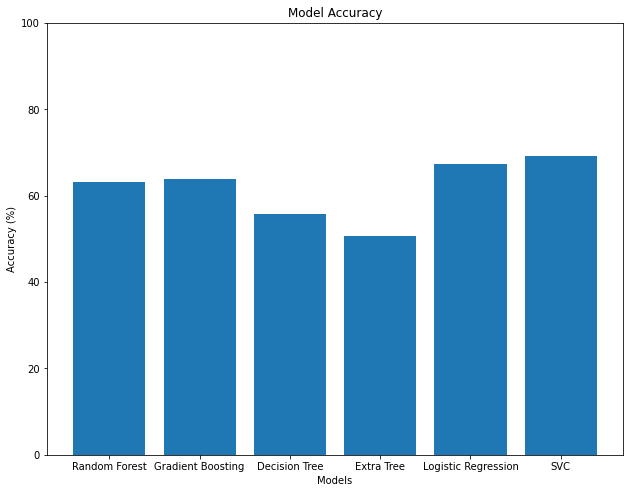

In [25]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_axes([0,0,1,1])
models = ['Random Forest', 'Gradient Boosting', 'Decision Tree', 'Extra Tree', 'Logistic Regression', 'SVC']
accuracies = [np.round(accuracy_rf*100,2), np.round(accuracy_gb*100,2), np.round(accuracy_dt*100,2), np.round(accuracy_et*100,2), np.round(accuracy_lr*100,2), np.round(accuracy_svc*100,2)]
ax.bar(models,accuracies)
# Set y-axis to be 0-100
ax.set_ylim(0,100)
ax.set_ylabel('Accuracy (%)')
ax.set_title('Model Accuracy')
ax.set_xlabel('Models')
plt.show()